# RelBench Arxiv Dataset - XGB - GNN
We use the RelBench arxiv dataset [here][1]. We build a graph using authors as nodes with coauthorship as edges. We define binary classification targets are "Did author publish in 2021?". We build graph and features from information before 2021.

Next we will train an XGB. And in a second notebook we train a GNN to improve the XGB.

[1]: https://relbench.stanford.edu/datasets/rel-arxiv/

# Load and Convert RelBench Arxiv Data

In [1]:
import os
os.environ["RELBENCH_CACHE_DIR"] = "/raid/cdeotte/.cache/relbench/rel-arxiv/"

VER=8

In [2]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

In [3]:
from relbench.datasets import get_dataset
dataset = get_dataset("rel-arxiv")

In [4]:
db = dataset.get_db()

Loading Database object from /raid/cdeotte/.cache/relbench/rel-arxiv//rel-arxiv/db...
Done in 1.20 seconds.


In [5]:
db.table_dict.keys()

dict_keys(['papers', 'citations', 'categories', 'paperCategories', 'paperAuthors', 'authors'])

# Create Author Targets (in 2021)
We define target as "Did author published paper in 2021?"

In [6]:
T = pd.Timestamp("2021-01-01")
T_end = T + pd.DateOffset(years=1)

authors_df = db.table_dict["authors"].df.copy()
paper_authors_df = db.table_dict["paperAuthors"].df.copy()
paper_authors_df["Submission_Date"] = pd.to_datetime(
    paper_authors_df["Submission_Date"]
)

future_authors = (
    paper_authors_df.loc[
        (paper_authors_df["Submission_Date"] > T) &
        (paper_authors_df["Submission_Date"] <= T_end),
        "Author_ID"
    ]
    .drop_duplicates()
)

author_targets = (
    authors_df[["Author_ID"]]
    .assign(
        target=lambda df: df["Author_ID"].isin(future_authors).astype("int8")
    )
)

author_targets.head()

,Author_ID,target
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [7]:
print("Target counts distribution:")
author_targets["target"].value_counts(normalize=True)

Target counts distribution:


target
0    0.574601
1    0.425399
Name: proportion, dtype: float64

# Create Author (as Nodes) Graph (Before Jan 1, 2021)
Find author edges based on co-author info before 2021

In [8]:
from itertools import combinations
from collections import Counter, defaultdict

paper_authors = db.table_dict["paperAuthors"].df.copy()
paper_authors["Submission_Date"] = pd.to_datetime(paper_authors["Submission_Date"])

paper_authors_hist = paper_authors[
    paper_authors["Submission_Date"] < T
]

In [9]:
paper_to_authors = (
    paper_authors_hist
    .groupby("Paper_ID")["Author_ID"]
    .apply(list)
)

In [10]:
%%time

coauthor_counter = defaultdict(Counter)

for authors in paper_to_authors:
    if len(authors) < 2:
        continue
    for a, b in combinations(authors, 2):
        coauthor_counter[a][b] += 1
        coauthor_counter[b][a] += 1

CPU times: user 3.72 s, sys: 55.6 ms, total: 3.78 s
Wall time: 3.78 s


In [11]:
def extract_coauthors(author_id):
    counter = coauthor_counter.get(author_id, {})
    if not counter:
        return [], []
    ids = [int(k) for k in counter.keys()]
    counts = [int(v) for v in counter.values()]

    return ids, counts

In [12]:
%%time 

coauthor_data = author_targets["Author_ID"].apply(extract_coauthors)

author_targets["coauthor_ids"] = coauthor_data.apply(lambda x: x[0])
author_targets["coauthor_counts"] = coauthor_data.apply(lambda x: x[1])

author_targets.head()

CPU times: user 2.28 s, sys: 124 ms, total: 2.4 s
Wall time: 2.4 s


,Author_ID,target,coauthor_ids,coauthor_counts
0,0,0,[],[]
1,1,0,"[2, 3, 4, 5, 6, 7, 8]","[1, 1, 1, 1, 1, 1, 1]"
2,2,0,"[1, 3, 4, 5, 6, 7, 8]","[1, 1, 1, 1, 1, 1, 1]"
3,3,0,"[1, 2, 4, 5, 6, 7, 8]","[1, 1, 1, 1, 1, 1, 1]"
4,4,0,"[1, 2, 3, 5, 6, 7, 8, 2905, 2819, 2906, 2907, ...","[1, 1, 1, 4, 4, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, ..."


In [13]:
print("Percentage authors without co-authors:")
(author_targets["coauthor_ids"].str.len() == 0).mean()

Percentage authors without co-authors:


np.float64(0.53366599160699)

# Graph EDA

In [14]:
author_targets["degree"] = author_targets["coauthor_ids"].apply(len)

deg = author_targets["degree"]

stats = {
    "num_authors": len(deg),
    "fraction_isolated": (deg == 0).mean(),
    "mean_degree": deg.mean(),
    "median_degree": deg.median(),
    "max_degree": deg.max(),
}

stats

{'num_authors': 143691,
 'fraction_isolated': np.float64(0.53366599160699),
 'mean_degree': np.float64(58.26433805875107),
 'median_degree': np.float64(0.0),
 'max_degree': np.int64(3387)}

In [15]:
deg_pos = deg[deg > 0]
{
    "mean_degree_nonzero": deg_pos.mean(),
    "median_degree_nonzero": deg_pos.median(),
}

{'mean_degree_nonzero': np.float64(124.94121597421203),
 'median_degree_nonzero': np.float64(4.0)}

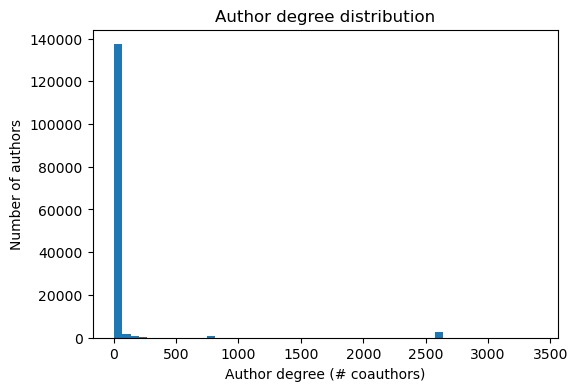

In [16]:
plt.figure(figsize=(6, 4))
plt.hist(deg, bins=50)
plt.xlabel("Author degree (# coauthors)")
plt.ylabel("Number of authors")
plt.title("Author degree distribution")
plt.show()

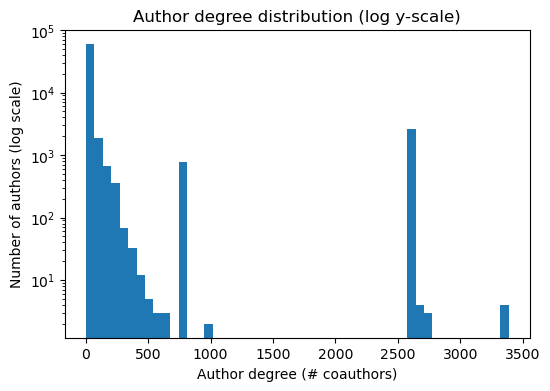

In [17]:
plt.figure(figsize=(6, 4))
plt.hist(deg[deg > 0], bins=50)
plt.yscale("log")
plt.xlabel("Author degree (# coauthors)")
plt.ylabel("Number of authors (log scale)")
plt.title("Author degree distribution (log y-scale)")
plt.show()

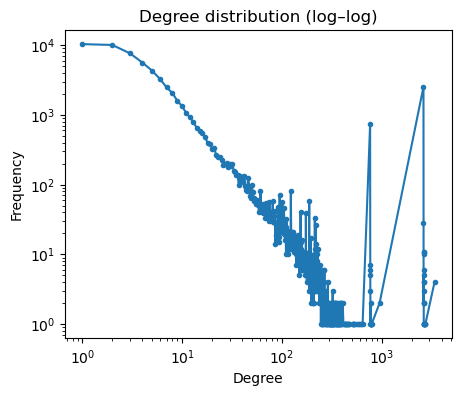

In [18]:
counts = deg.value_counts().sort_index()
counts = counts[counts.index > 0]

plt.figure(figsize=(5, 4))
plt.plot(counts.index, counts.values, marker=".")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.title("Degree distribution (log–log)")
plt.show()

In [19]:
all_edge_weights = np.concatenate(
    author_targets["coauthor_counts"].values
)
pd.Series(all_edge_weights).describe()

count    8.372061e+06
mean     1.078427e+00
std      6.384008e-01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      6.800000e+01
dtype: float64

In [20]:
print("Repeat collaborations 2:")
print( (pd.Series(all_edge_weights) >= 2).mean() )   
print("Repeat collaborations 5:")
print( (pd.Series(all_edge_weights) >= 5).mean() )

Repeat collaborations 2:
0.029406976370573507
Repeat collaborations 5:
0.00658451963023203


# Feature Engineer - Author (Node) Features

# Feature Engineer about Co-author Stats and Paper Publish Stats

In [21]:
def entropy(counts):
    if len(counts) == 0:
        return 0.0
    p = np.array(counts, dtype=float)
    p = p / p.sum()
    return -(p * np.log(p + 1e-12)).sum()

In [22]:
author_feats = author_targets[["Author_ID"]].copy()

author_feats["n_coauthors"] = author_targets["coauthor_ids"].apply(len)

author_feats["total_collaborations"] = author_targets["coauthor_counts"].apply(
    lambda x: int(np.sum(x)) if len(x) else 0
)

author_feats["avg_collab_strength"] = author_targets["coauthor_counts"].apply(
    lambda x: float(np.mean(x)) if len(x) else 0.0
)

author_feats["max_collab_strength"] = author_targets["coauthor_counts"].apply(
    lambda x: int(np.max(x)) if len(x) else 0
)

author_feats["collab_entropy"] = author_targets["coauthor_counts"].apply(entropy)

In [23]:
paper_authors = db.table_dict["paperAuthors"].df.copy()
papers = db.table_dict["papers"].df.copy()

paper_authors["Submission_Date"] = pd.to_datetime(paper_authors["Submission_Date"])
papers["Submission_Date"] = pd.to_datetime(papers["Submission_Date"])

paper_authors_hist = paper_authors[paper_authors["Submission_Date"] < T]
papers_hist = papers[papers["Submission_Date"] < T]

In [24]:
total_papers = (
    paper_authors_hist
    .groupby("Author_ID")
    .size()
    .rename("total_papers")
)

In [25]:
papers_last_1y = (
    paper_authors_hist[
        paper_authors_hist["Submission_Date"] >= (T - pd.DateOffset(years=1))
    ]
    .groupby("Author_ID")
    .size()
    .rename("papers_last_1y")
)

In [26]:
papers_last_3y = (
    paper_authors_hist[
        paper_authors_hist["Submission_Date"] >= (T - pd.DateOffset(years=3))
    ]
    .groupby("Author_ID")
    .size()
    .rename("papers_last_3y")
)

In [27]:
last_pub_date = (
    paper_authors_hist
    .groupby("Author_ID")["Submission_Date"]
    .max()
)

time_since_last_paper = (
    (T - last_pub_date).dt.days
    .rename("days_since_last_paper")
)

In [28]:
author_feats = (
    author_feats
    .merge(total_papers, on="Author_ID", how="left")
    .merge(papers_last_1y, on="Author_ID", how="left")
    .merge(papers_last_3y, on="Author_ID", how="left")
    .merge(time_since_last_paper, on="Author_ID", how="left")
)

author_feats.fillna({
    "total_papers": 0,
    "papers_last_1y": 0,
    "papers_last_3y": 0,
    "days_since_last_paper": 10_000,  # effectively "never"
}, inplace=True)

In [29]:
author_features = (
    author_targets[["Author_ID", "target"]]
    .merge(author_feats, on="Author_ID", how="left")
)

In [30]:
author_features.head()

,Author_ID,target,n_coauthors,total_collaborations,avg_collab_strength,max_collab_strength,collab_entropy,total_papers,papers_last_1y,papers_last_3y,days_since_last_paper
0,0,0,0,0,0.000000,0,0.000000,1.0,0.0,1.0,1096.0
1,1,0,7,7,1.000000,1,1.945910,1.0,0.0,1.0,1096.0
2,2,0,7,7,1.000000,1,1.945910,1.0,0.0,1.0,1096.0
3,3,0,7,7,1.000000,1,1.945910,1.0,0.0,1.0,1096.0
4,4,0,38,48,1.263158,4,3.524627,6.0,2.0,6.0,43.0


In [31]:
author_features.describe()

,Author_ID,target,n_coauthors,total_collaborations,avg_collab_strength,max_collab_strength,collab_entropy,total_papers,papers_last_1y,papers_last_3y,days_since_last_paper
count,143691.0,143691.000000,143691.000000,143691.000000,143691.000000,143691.000000,1.436910e+05,143691.000000,143691.000000,143691.000000,143691.000000
mean,71845.0,0.425399,58.264338,62.833859,0.553965,0.841340,8.797789e-01,1.357803,0.660967,1.357803,4830.539136
std,41480.163102,0.494405,355.327363,359.879291,0.674985,1.730778,1.536354e+00,2.986775,1.407791,2.986775,4848.924318
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000089e-12,0.000000,0.000000,0.000000,1.000000
25%,35922.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,181.000000
50%,71845.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.000000,0.000000,1.000000,850.000000
75%,107767.5,1.000000,4.000000,4.000000,1.000000,1.000000,1.386294e+00,1.000000,1.000000,1.000000,10000.000000
max,143690.0,1.000000,3387.000000,3390.000000,8.521739,68.000000,8.127358e+00,229.000000,119.000000,229.000000,10000.000000


# Feature Engineer about Paper Topic

In [32]:
paper_categories = db.table_dict["paperCategories"].df.copy()
paper_categories["Submission_Date"] = pd.to_datetime(paper_categories["Submission_Date"])

paper_categories_hist = paper_categories[paper_categories["Submission_Date"] < T]

# Join author ↔ paper ↔ category
author_paper_cat = (
    paper_authors_hist
    .merge(paper_categories_hist[["Paper_ID", "Category_ID"]],
           on="Paper_ID",
           how="left")
)

In [33]:
author_cat_counts = (
    author_paper_cat
    .groupby(["Author_ID", "Category_ID"])
    .size()
    .rename("n_papers_cat")
    .reset_index()
)

In [34]:
top_cat = (
    author_cat_counts
    .sort_values(["Author_ID", "n_papers_cat"], ascending=[True, False])
    .groupby("Author_ID")
    .first()
    .rename(columns={
        "Category_ID": "top_category",
        "n_papers_cat": "top_category_papers"
    })
)

In [35]:
total_cat_papers = (
    author_cat_counts
    .groupby("Author_ID")["n_papers_cat"]
    .sum()
    .rename("total_category_papers")
)

In [36]:
category_dominance = (
    top_cat["top_category_papers"] / total_cat_papers
).rename("top_category_frac")

In [37]:
def cat_entropy(x):
    p = x / x.sum()
    return -(p * np.log(p + 1e-12)).sum()

category_entropy = (
    author_cat_counts
    .groupby("Author_ID")["n_papers_cat"]
    .apply(cat_entropy)
    .rename("category_entropy")
)

In [38]:
author_features = (
    author_features
    .merge(top_cat[["top_category"]], on="Author_ID", how="left")
    .merge(category_dominance, on="Author_ID", how="left")
    .merge(category_entropy, on="Author_ID", how="left")
)

author_features.fillna({
    "top_category": -1,
    "top_category_frac": 0.0,
    "category_entropy": 0.0,
}, inplace=True)

In [39]:
author_features.head()

,Author_ID,target,n_coauthors,total_collaborations,avg_collab_strength,max_collab_strength,collab_entropy,total_papers,papers_last_1y,papers_last_3y,days_since_last_paper,top_category,top_category_frac,category_entropy
0,0,0,0,0,0.000000,0,0.000000,1.0,0.0,1.0,1096.0,-1,0.0,0.0
1,1,0,7,7,1.000000,1,1.945910,1.0,0.0,1.0,1096.0,-1,0.0,0.0
2,2,0,7,7,1.000000,1,1.945910,1.0,0.0,1.0,1096.0,-1,0.0,0.0
3,3,0,7,7,1.000000,1,1.945910,1.0,0.0,1.0,1096.0,-1,0.0,0.0
4,4,0,38,48,1.263158,4,3.524627,6.0,2.0,6.0,43.0,-1,0.0,0.0


# Feature Engineer about Citations

In [40]:
citations = db.table_dict["citations"].df.copy()
citations["Submission_Date"] = pd.to_datetime(citations["Submission_Date"])

citations_hist = citations[citations["Submission_Date"] < T]

# cited paper → citing paper
paper_citation_counts = (
    citations_hist
    .groupby("References_Paper_ID")
    .size()
    .rename("n_citations")
)

In [41]:
author_citations = (
    paper_authors_hist
    .merge(paper_citation_counts,
           left_on="Paper_ID",
           right_index=True,
           how="left")
)

author_citations["n_citations"] = author_citations["n_citations"].fillna(0)

In [42]:
total_citations = (
    author_citations
    .groupby("Author_ID")["n_citations"]
    .sum()
    .rename("total_citations")
)

avg_citations = (
    author_citations
    .groupby("Author_ID")["n_citations"]
    .mean()
    .rename("avg_citations_per_paper")
)

max_citations = (
    author_citations
    .groupby("Author_ID")["n_citations"]
    .max()
    .rename("max_citations_single_paper")
)

In [43]:
recent_papers = paper_authors_hist[
    paper_authors_hist["Submission_Date"] >= (T - pd.DateOffset(years=3))
]

recent_citations = (
    recent_papers
    .merge(paper_citation_counts,
           left_on="Paper_ID",
           right_index=True,
           how="left")
)

recent_citations["n_citations"] = recent_citations["n_citations"].fillna(0)

recent_citation_sum = (
    recent_citations
    .groupby("Author_ID")["n_citations"]
    .sum()
    .rename("citations_last_3y")
)

In [44]:
author_features = (
    author_features
    .merge(total_citations, on="Author_ID", how="left")
    .merge(avg_citations, on="Author_ID", how="left")
    .merge(max_citations, on="Author_ID", how="left")
    .merge(recent_citation_sum, on="Author_ID", how="left")
)

author_features.fillna({
    "total_citations": 0,
    "avg_citations_per_paper": 0.0,
    "max_citations_single_paper": 0,
    "citations_last_3y": 0,
}, inplace=True)

In [45]:
author_features.head()

,Author_ID,target,n_coauthors,total_collaborations,avg_collab_strength,max_collab_strength,collab_entropy,total_papers,papers_last_1y,papers_last_3y,days_since_last_paper,top_category,top_category_frac,category_entropy,total_citations,avg_citations_per_paper,max_citations_single_paper,citations_last_3y
0,0,0,0,0,0.000000,0,0.000000,1.0,0.0,1.0,1096.0,-1,0.0,0.0,0.0,0.000000,0.0,0.0
1,1,0,7,7,1.000000,1,1.945910,1.0,0.0,1.0,1096.0,-1,0.0,0.0,2.0,2.000000,2.0,2.0
2,2,0,7,7,1.000000,1,1.945910,1.0,0.0,1.0,1096.0,-1,0.0,0.0,2.0,2.000000,2.0,2.0
3,3,0,7,7,1.000000,1,1.945910,1.0,0.0,1.0,1096.0,-1,0.0,0.0,2.0,2.000000,2.0,2.0
4,4,0,38,48,1.263158,4,3.524627,6.0,2.0,6.0,43.0,-1,0.0,0.0,20.0,3.333333,10.0,20.0


# Save Data

In [46]:
author_features.to_parquet(f"data/author_features_v{VER}.pqt",index=False)
author_targets.to_parquet(f"data/author_targets_v{VER}.pqt",index=False)